# Lets try to forecast the demand of each product

In [1]:
import pandas as pd
df = pd.read_csv("online_retail_II.csv")
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


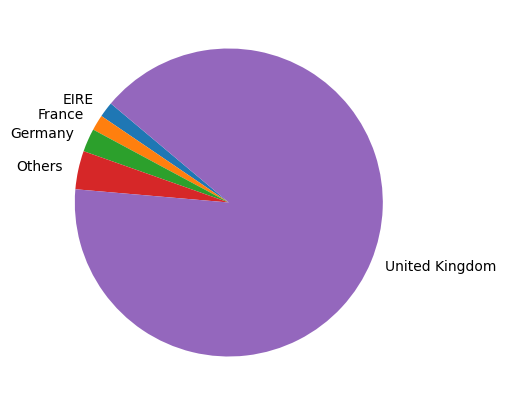

In [2]:
df_unique_clients = df.drop_duplicates(subset='Invoice',inplace=False)
clients_per_country = df_unique_clients.groupby('Country').count().sort_values(by='Customer ID', ascending=False)['Customer ID']


#pie plotting
min_clients_to_appear = clients_per_country.sum()/100
clients_per_country_for_barplot=clients_per_country.copy()
clients_per_country_for_barplot.index = [
    idx if value > min_clients_to_appear else 'Others'
    for idx, value in clients_per_country.items()
]
clients_per_country_for_barplot = clients_per_country_for_barplot.groupby(level=0).sum()#sum is made to really group the other coutries clients
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.pie(clients_per_country_for_barplot, labels=clients_per_country_for_barplot.index, startangle=140)
plt.show()

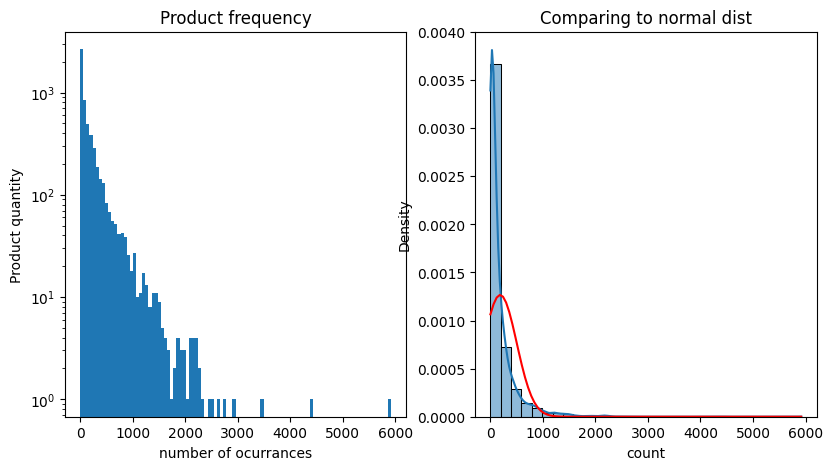

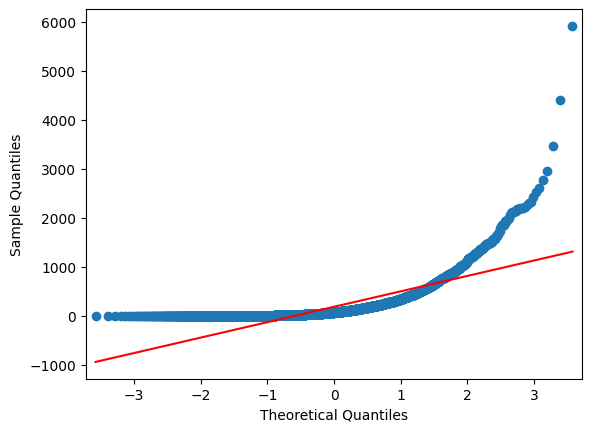

5698

In [3]:
import seaborn as sns
from scipy.stats import norm
import numpy as np

product_counts = df['Description'].value_counts()
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(product_counts, bins=100, log=True)# escala log 
plt.xlabel('number of ocurrances')
plt.ylabel('Product quantity')
plt.title('Product frequency')

plt.subplot(1, 3, 2)
sns.histplot(product_counts, kde=True, stat='density', bins=30)
x = np.linspace(min(product_counts), max(product_counts), 100)
plt.plot(
    x,
    norm.pdf(x, np.mean(product_counts), np.std(product_counts)),
    color='red'
)
plt.title('Comparing to normal dist')

from statsmodels.graphics.gofplots import qqplot
plt.subplot(1, 3, 2)
qqplot(product_counts, line='s')
plt.show()

len(product_counts)


As expected, the product frequency distribution is not normal, lets see how can we remove the outlyers, i will use MAD algorithm since this one is more useful for our type of distribution

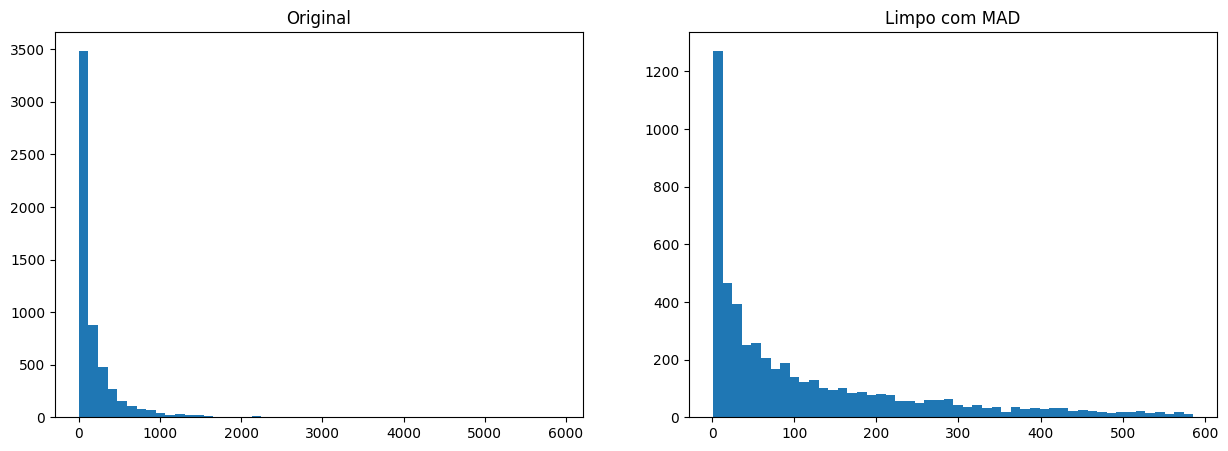

qtd_compras=53628
qtd_produtos=5698
porcentagem de outlyers 8.4
porcentagem de outlyers inferiores 4.2
porcentagem de outlyers superiores 4.2


In [4]:
from scipy.stats import median_abs_deviation

def remove_exponential_outliers(series, mad_thresh=3.5):
    median = series.median()
    mad = median_abs_deviation(series, scale='normal')
    modified_z = 0.6745 * (series - median) / mad
    clean_data = series[~(modified_z.abs() >= mad_thresh)]
    outlyers = series[(modified_z.abs() >= mad_thresh)]
    return clean_data, outlyers


product_counts_clean,product_counts_outlyers = remove_exponential_outliers(product_counts)

# Compare visualmente
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(product_counts, bins=50)
plt.title('Original')
plt.subplot(1, 2, 2)
plt.hist(product_counts_clean, bins=50)
plt.title('Limpo com MAD')
plt.show()
print("qtd_compras="+str(len(df['Invoice'].value_counts())))
print("qtd_produtos="+str(len(product_counts)))
print("porcentagem de outlyers "+str(round(100*len(product_counts_outlyers)/len(product_counts_clean),1)))
print("porcentagem de outlyers inferiores "+str(round(100*len(product_counts_outlyers[product_counts_outlyers.median()<product_counts_outlyers])/len(product_counts_clean),1)))
print("porcentagem de outlyers superiores "+str(round(100*len(product_counts_outlyers[product_counts_outlyers.median()>product_counts_outlyers])/len(product_counts_clean),1)))


In [5]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [6]:
#making sure there are no repeats of products, even if the price changes (may be a different product)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
group_cols = [col for col in df.columns if col not in ['Quantity','StockCode','Price', 'InvoiceDate']]
print(group_cols)
df_grouped_item_names = df.groupby(group_cols, as_index=False).agg({'Quantity': 'sum', 'InvoiceDate': 'min'})
print(str(len(df_grouped_item_names)))


['Invoice', 'Description', 'Customer ID', 'Country']
786881


In [7]:
# Find repeating items in the same InvoiceDate
repeats = df_grouped_item_names.groupby(['Invoice', 'Description']).size().reset_index(name='count')
repeats = repeats[repeats['count'] > 1]
print(repeats)

Empty DataFrame
Columns: [Invoice, Description, count]
Index: []


### Now we will clusterize the products to facilitate each type of product demand forecasting

In [8]:
basket = df_grouped_item_names.groupby(['Invoice', 'Description']).size().unstack(fill_value=0)
basket = basket > 0

In [9]:
from mlxtend.frequent_patterns import fpgrowth, association_rules

MIN_lift = 0.7
MIN_leverage = 0.01

#Using fp-growth
frequent_itemsets = fpgrowth(basket, min_support=0.01, use_colnames=True)
# getting the asociation rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
#selecting only good realtionships
rules = rules[(rules['lift']>MIN_lift)|(rules['leverage']>MIN_leverage)]
rules['lift x leverage']=rules['lift']*rules['leverage']

In [10]:
import networkx as nx
from networkx.algorithms.community import k_clique_communities

# create the 
G = nx.Graph()
for _, row in rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            if G.has_edge(a, c):
                G[a][c]['weight'] += row['lift x leverage']
            else:
                G.add_edge(a, c, weight=row['lift x leverage'])

#create the cluster
k = 2 #at least a relation of 3 products for a communitie
communities = list(k_clique_communities(G, k))
overlapping_clusters = [set(comm) for comm in communities]

for i, c in enumerate(overlapping_clusters):
    print(f"Cluster {i}: {c}")

Cluster 0: {'PLASTERS IN TIN WOODLAND ANIMALS', 'PLASTERS IN TIN CIRCUS PARADE ', 'PLASTERS IN TIN SPACEBOY'}
Cluster 1: {'HAND WARMER OWL DESIGN', 'HAND WARMER BIRD DESIGN', 'HAND WARMER SCOTTY DOG DESIGN'}
Cluster 2: {'WOOD S/3 CABINET ANT WHITE FINISH', 'HOME BUILDING BLOCK WORD', 'SWEETHEART CERAMIC TRINKET BOX', 'HEART OF WICKER SMALL', 'LOVE BUILDING BLOCK WORD', 'ASSORTED COLOUR BIRD ORNAMENT', 'WHITE HANGING HEART T-LIGHT HOLDER', 'PINK REGENCY TEACUP AND SAUCER', 'STRAWBERRY CERAMIC TRINKET BOX', 'REGENCY CAKESTAND 3 TIER', 'PAINTED METAL PEARS ASSORTED', 'RED HANGING HEART T-LIGHT HOLDER', 'CREAM HEART CARD HOLDER', 'WOODEN PICTURE FRAME WHITE FINISH', 'GREEN REGENCY TEACUP AND SAUCER', 'WOOD 2 DRAWER CABINET WHITE FINISH', 'HEART OF WICKER LARGE', 'NATURAL SLATE HEART CHALKBOARD ', 'WOODEN FRAME ANTIQUE WHITE ', 'ZINC METAL HEART DECORATION', 'ROSES REGENCY TEACUP AND SAUCER '}
Cluster 3: {'CHOCOLATE HOT WATER BOTTLE', 'HOT WATER BOTTLE TEA AND SYMPATHY', 'SCOTTIE DOG HOT WA

Computing the sells of each community, day by day

In [11]:
df_grouped_item_names.columns

Index(['Invoice', 'Description', 'Customer ID', 'Country', 'Quantity',
       'InvoiceDate'],
      dtype='object')

In [12]:
df_grouped_item_names['InvoiceDate'] = df_grouped_item_names['InvoiceDate'].dt.normalize()

min_date = df_grouped_item_names['InvoiceDate'].min()
max_date = df_grouped_item_names['InvoiceDate'].max()
date_range = pd.date_range(start=min_date, end=max_date, freq='W')

product_sales = pd.DataFrame(columns=['Description'] + list(date_range))
cluster_sales_as_dict={}
for c in overlapping_clusters:
    for p in c:
        if(len(product_sales[product_sales['Description']==str(p)])!=0):
            continue
        row = {'Description': p}
        p_appearences = df_grouped_item_names[df_grouped_item_names['Description']==str(p)]
        for i, date in enumerate(date_range):
            if(i==(len(date_range)-1)):
                row[date] = p_appearences[p_appearences['InvoiceDate']>date]['Quantity'].sum()
            else:
                row[date] = p_appearences[(p_appearences['InvoiceDate']>date) & (p_appearences['InvoiceDate']<date_range[i+1])]['Quantity'].sum()
        product_sales = pd.concat([product_sales, pd.DataFrame([row])], ignore_index=True)


exclude_cols = ['Description']
date_cols = [col for col in product_sales.columns if col not in exclude_cols]
total_product_sales = product_sales[date_cols].sum(axis=1)
#normalyzing so we have no problem when summing it with others for the cluster seasonality analisys
product_sales[date_cols] = product_sales[date_cols].div(total_product_sales, axis=0)
product_sales.head()



,Description,2009-12-06 00:00:00,2009-12-13 00:00:00,2009-12-20 00:00:00,2009-12-27 00:00:00,2010-01-03 00:00:00,2010-01-10 00:00:00,2010-01-17 00:00:00,2010-01-24 00:00:00,2010-01-31 00:00:00,...,2011-10-02 00:00:00,2011-10-09 00:00:00,2011-10-16 00:00:00,2011-10-23 00:00:00,2011-10-30 00:00:00,2011-11-06 00:00:00,2011-11-13 00:00:00,2011-11-20 00:00:00,2011-11-27 00:00:00,2011-12-04 00:00:00
0,PLASTERS IN TIN WOODLAND ANIMALS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.012049,0.01266,0.026718,0.012573,0.014407,0.009866,0.008207,0.03152,0.00812,0.008644
1,PLASTERS IN TIN CIRCUS PARADE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.007975,0.009373,0.012744,0.015292,0.003206,0.008057,0.008551,0.022034,0.010195,0.013319
2,PLASTERS IN TIN SPACEBOY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011987,0.010231,0.010766,0.012598,0.008933,0.01466,0.011682,0.018707,0.011071,0.014507
3,HAND WARMER OWL DESIGN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.042181,0.014295,0.031245,0.015623,0.03437,0.053663,0.030073,0.025309,0.039603,0.046633
4,HAND WARMER BIRD DESIGN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.026685,0.011921,0.022375,0.014947,0.03127,0.038423,0.024026,0.020174,0.016873,0.054195


In [13]:
print(min_date)
print(max_date)

2009-12-01 00:00:00
2011-12-09 00:00:00


In [14]:
cluster_sales = pd.DataFrame(columns=['Cluster_id'] + list(date_range))
for i, c in enumerate(overlapping_clusters):
    row = {'Cluster_id':i}
    cluster_products = product_sales[product_sales['Description'].map(lambda x: x in c)]
    
    for date in date_range:
        row[date] = cluster_products[date].sum()
    cluster_sales = pd.concat([cluster_sales, pd.DataFrame([row])], ignore_index=True)

not_month_cols = ['Cluster_id','MonthlySalesMean','MonthlySalesStddev']
date_cols = [c for c in cluster_sales.columns if c not in not_month_cols]
cluster_sales['MonthlySalesMean'] = cluster_sales[date_cols].mean(axis=1)
cluster_sales['MonthlySalesStddev'] = cluster_sales[date_cols].std(axis=1)
cluster_sales.head()


/tmp/ipykernel_7229/2185230957.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_sales = pd.concat([cluster_sales, pd.DataFrame([row])], ignore_index=True)


,Cluster_id,2009-12-06 00:00:00,2009-12-13 00:00:00,2009-12-20 00:00:00,2009-12-27 00:00:00,2010-01-03 00:00:00,2010-01-10 00:00:00,2010-01-17 00:00:00,2010-01-24 00:00:00,2010-01-31 00:00:00,...,2011-10-16 00:00:00,2011-10-23 00:00:00,2011-10-30 00:00:00,2011-11-06 00:00:00,2011-11-13 00:00:00,2011-11-20 00:00:00,2011-11-27 00:00:00,2011-12-04 00:00:00,MonthlySalesMean,MonthlySalesStddev
0,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.050227,0.040464,0.026546,0.032583,0.028440,0.072261,0.029386,0.036470,0.028571,0.022584
1,1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.080348,0.039087,0.099254,0.160764,0.081009,0.053365,0.092899,0.140604,0.028571,0.060825
2,2,0.260783,0.241756,0.026990,0.0,0.125652,0.161984,0.163357,0.134576,0.116611,...,0.197914,0.097025,0.319518,0.175091,0.202242,0.199280,0.294798,0.236789,0.200000,0.106354
3,3,0.151983,0.137435,0.026761,0.0,0.025960,0.045304,0.012629,0.015826,0.014437,...,0.093364,0.067795,0.066933,0.168341,0.171474,0.096320,0.167333,0.123227,0.038095,0.053123
4,4,0.051394,0.071802,0.073240,0.0,0.070462,0.049866,0.120857,0.113222,0.042049,...,0.037385,0.034065,0.016467,0.017806,0.039977,0.026932,0.021709,0.016567,0.057143,0.038596


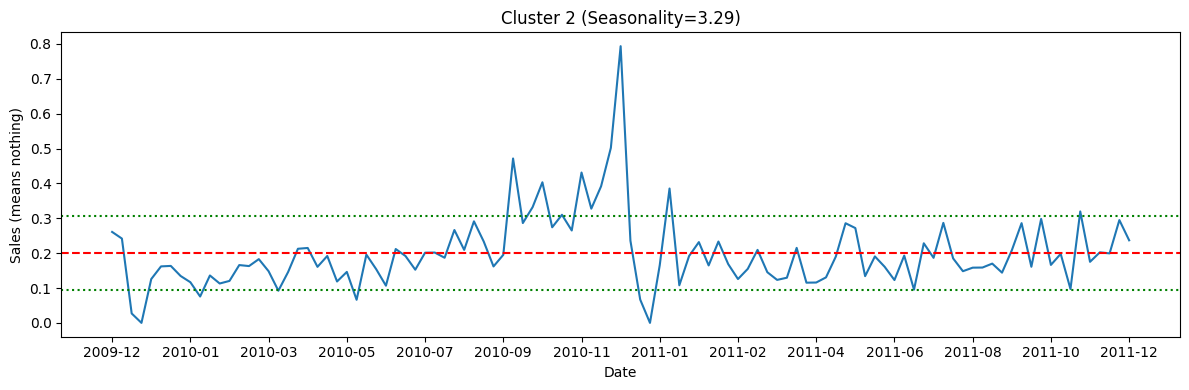

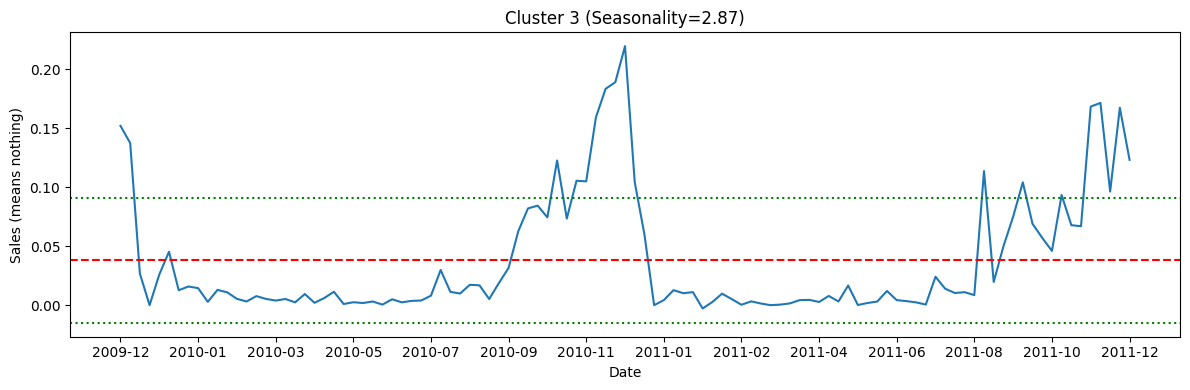

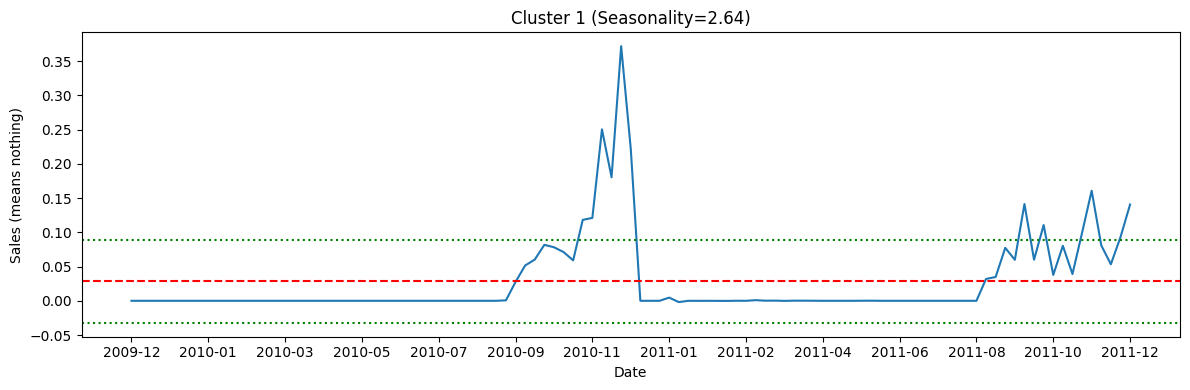

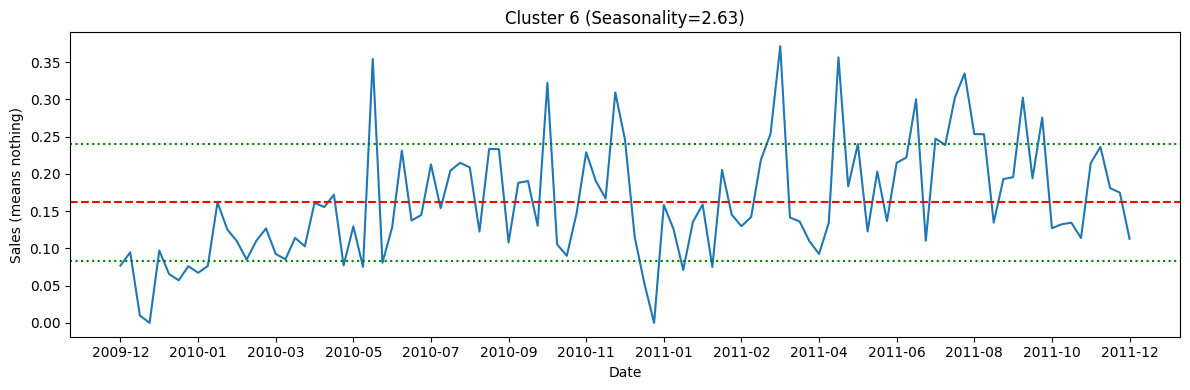

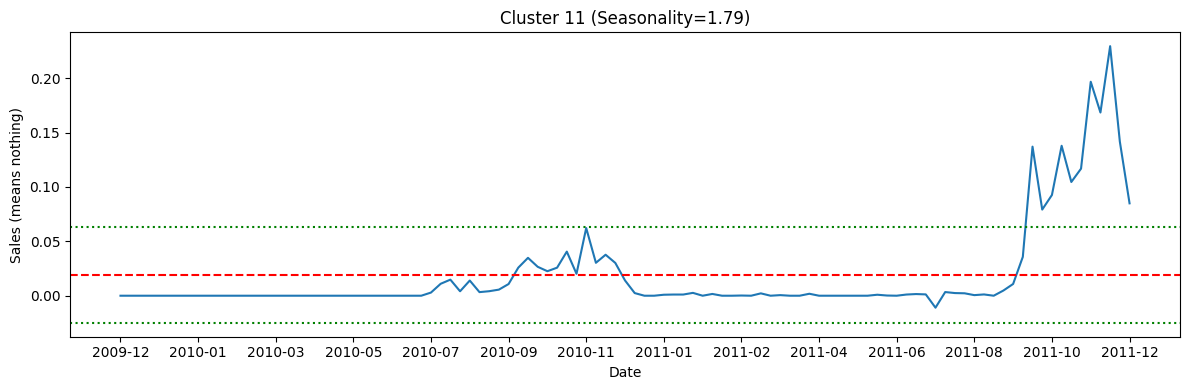

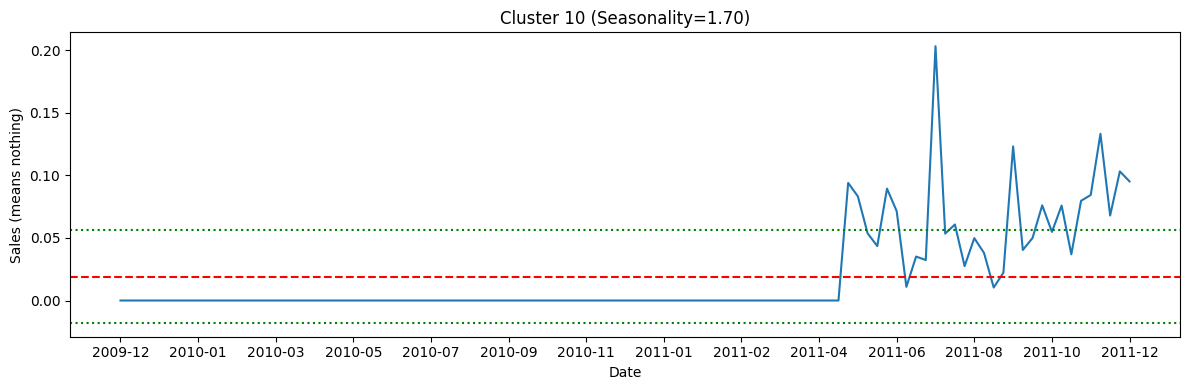

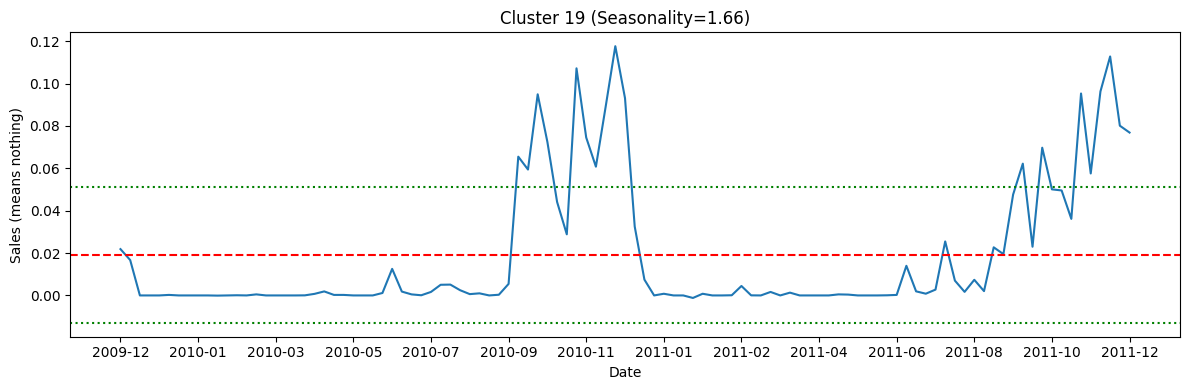

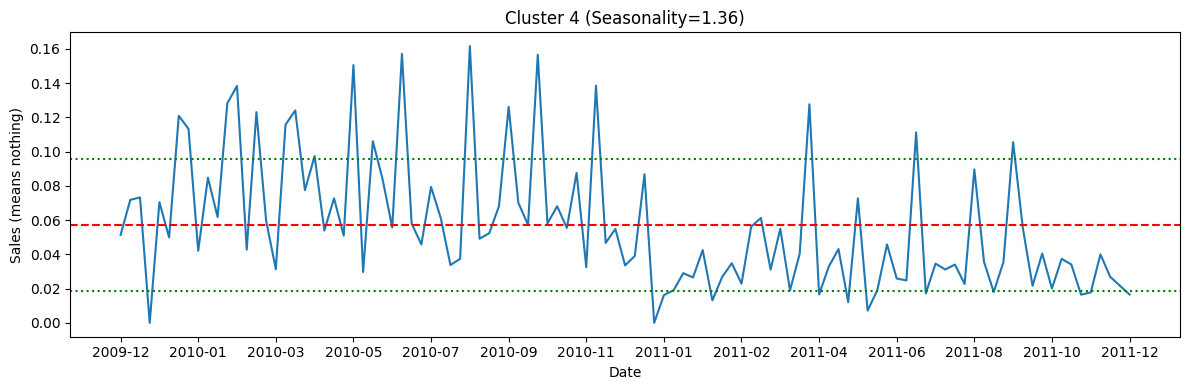

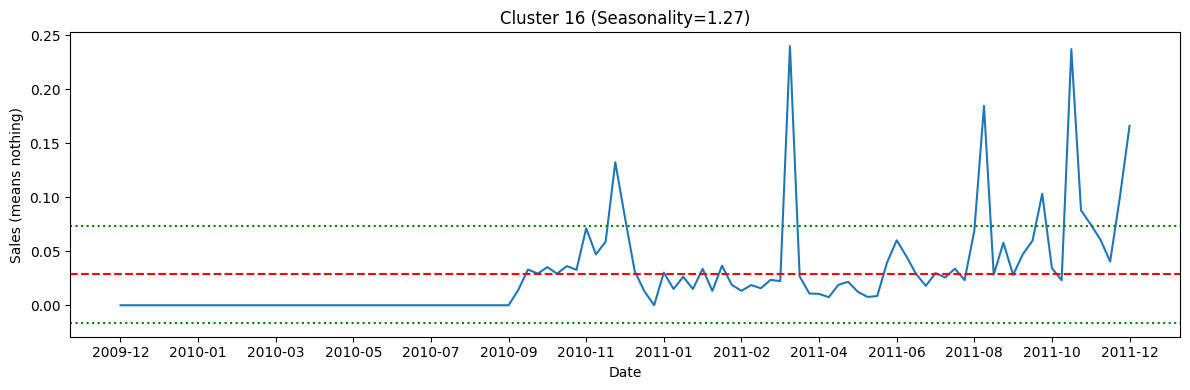

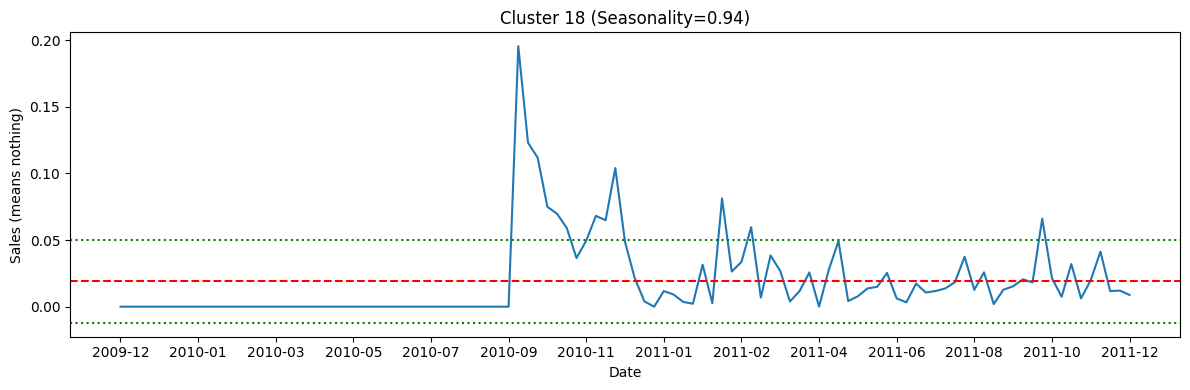

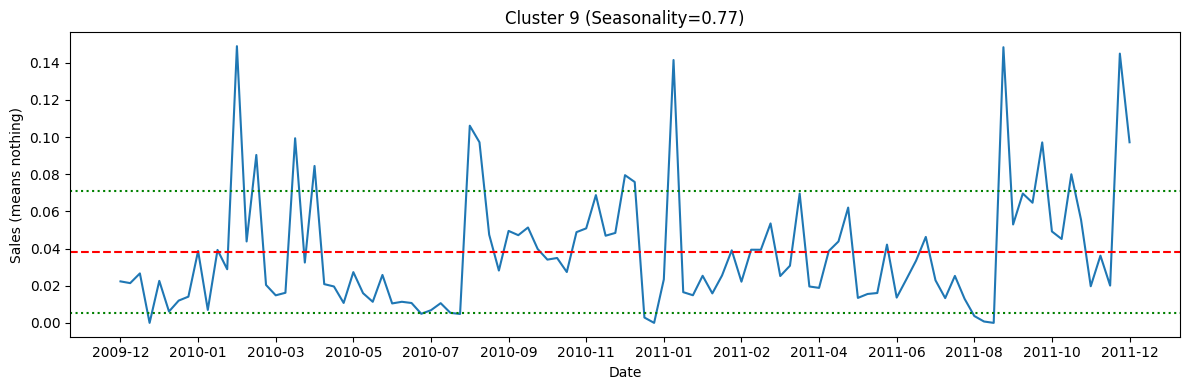

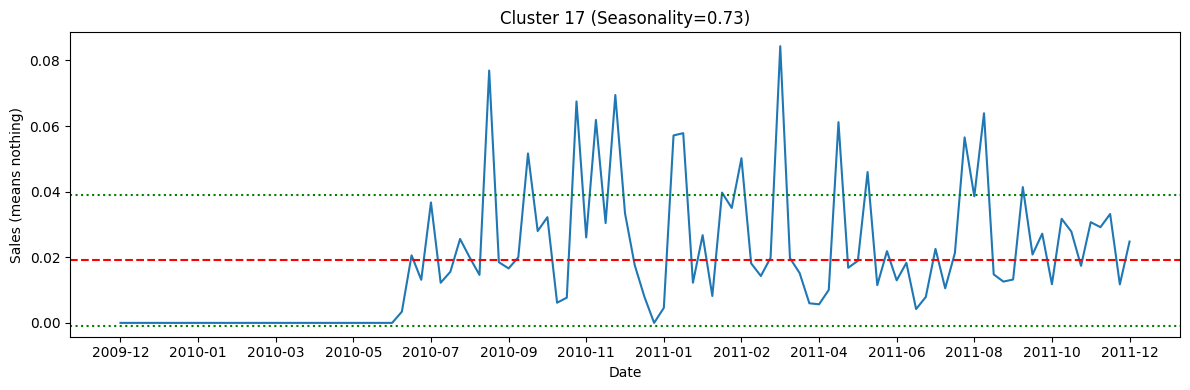

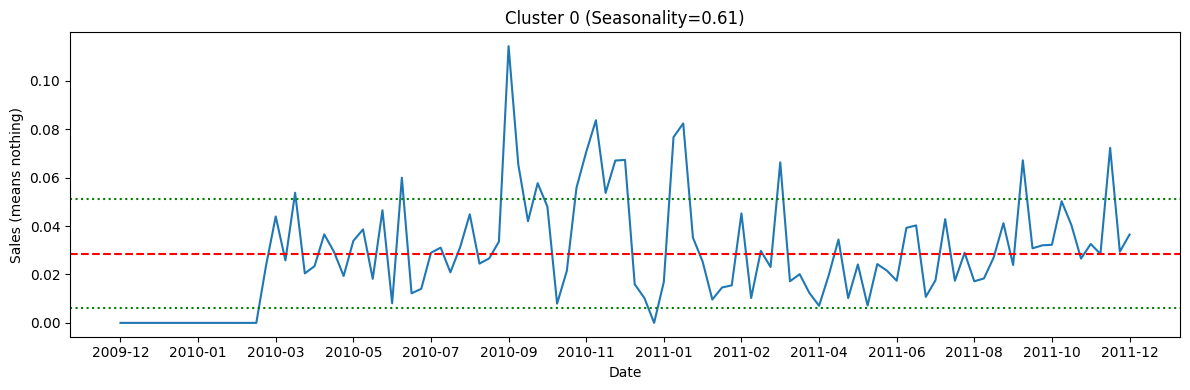

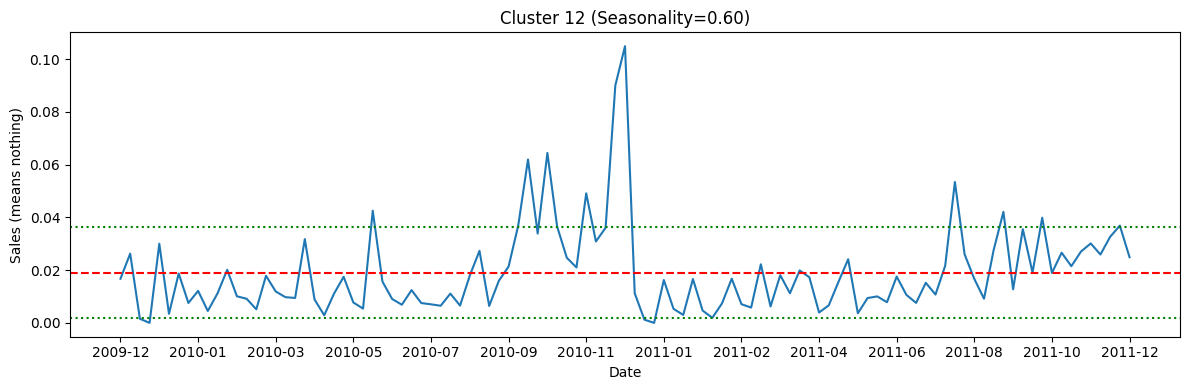

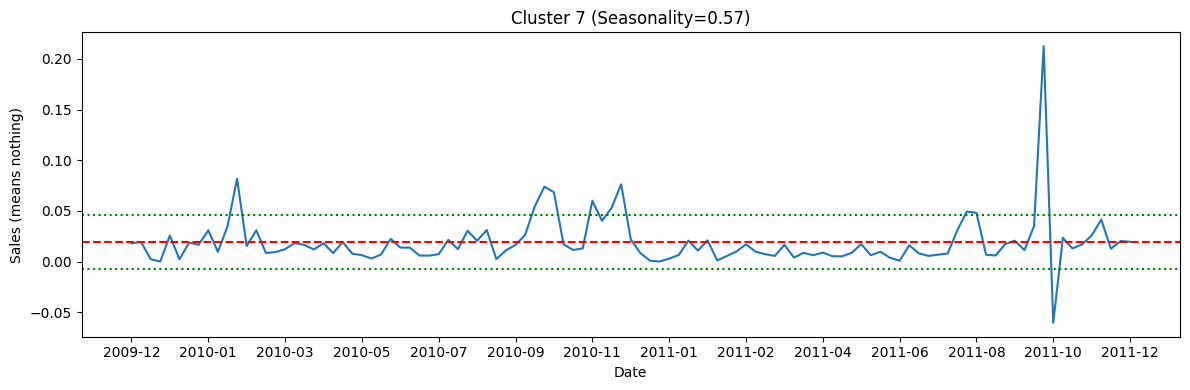

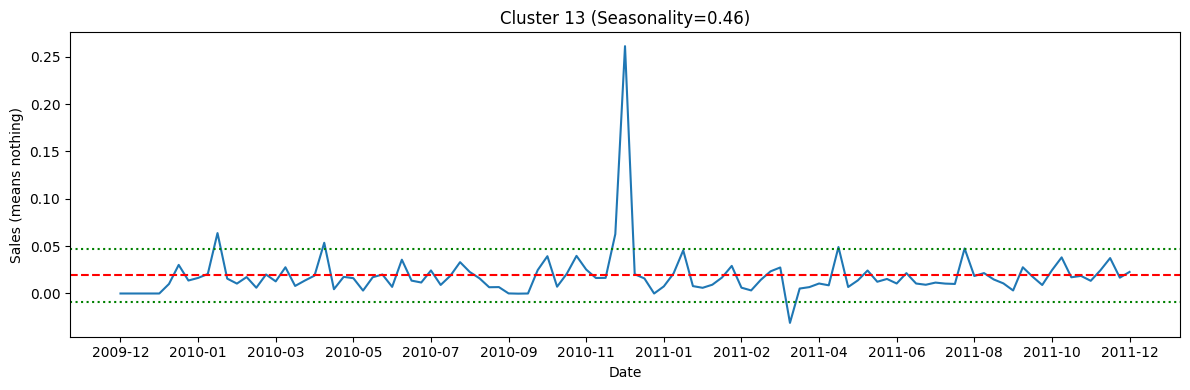

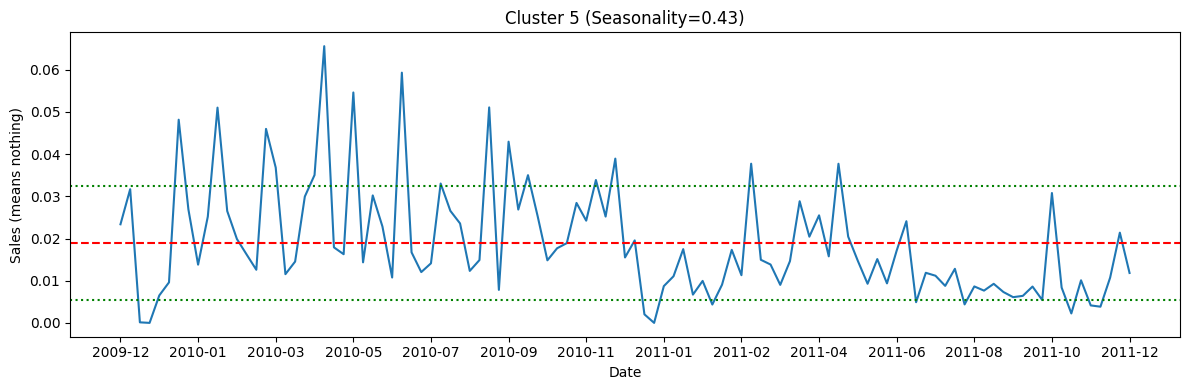

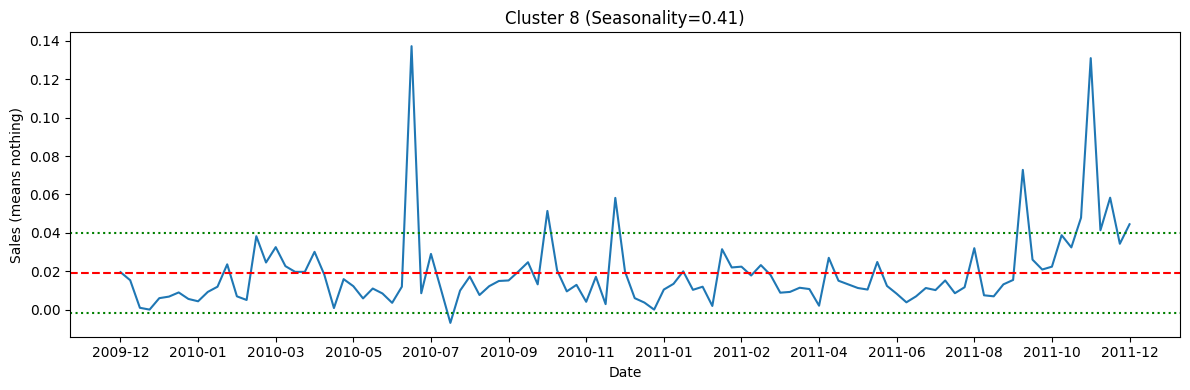

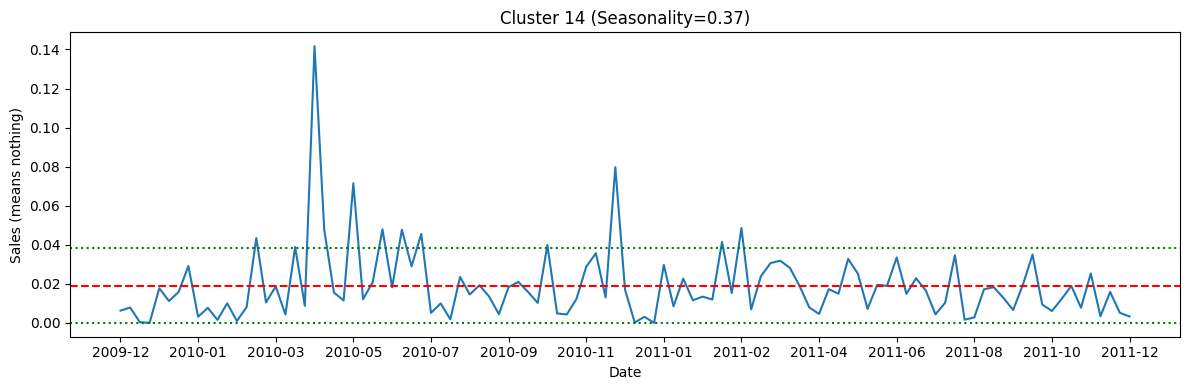

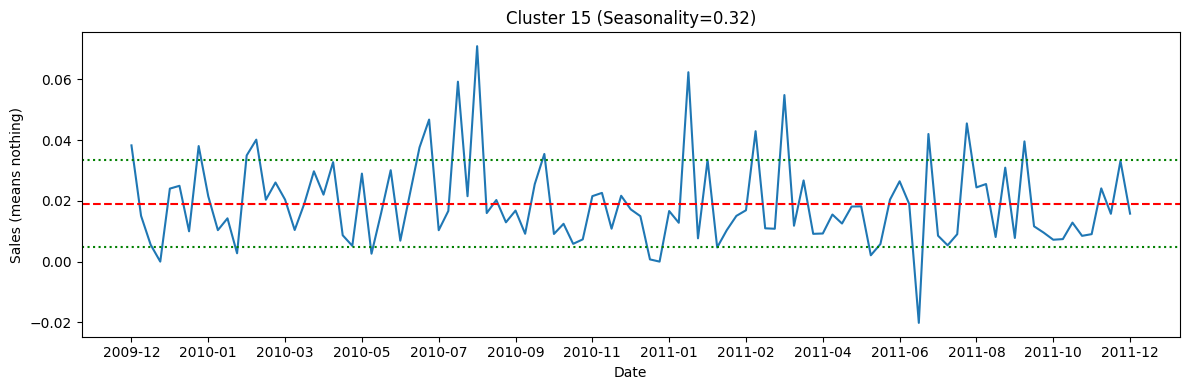

In [15]:
import numpy as np
from matplotlib.dates import DateFormatter

seasonality_strengths = []

for i, row in cluster_sales.iterrows():
    sales = row[date_cols].values.astype(float)
    fft = np.fft.fft(sales - np.mean(sales))
    fft_power = np.abs(fft)
    # Ignore the zero-frequency (trend) component
    seasonal_power = fft_power[1:len(fft_power)//2].max()
    seasonality_strengths.append((i, seasonal_power))

# Sort clusters by seasonality strength (descending)
seasonality_strengths.sort(key=lambda x: x[1], reverse=True)

for idx, strength in seasonality_strengths:
    row = cluster_sales.loc[idx]
    plt.figure(figsize=(12, 4))
    plt.plot(date_cols, cluster_sales.loc[idx, date_cols])
    mean_sales = plt.axhline(row['MonthlySalesMean'], color='red', linestyle='--', label='Mean')
    lower_std_limit = plt.axhline(row['MonthlySalesMean'] + row['MonthlySalesStddev'], color='green', linestyle=':', label='+1 Stddev')
    upper_std_limit = plt.axhline(row['MonthlySalesMean'] - row['MonthlySalesStddev'], color='green', linestyle=':', label='-1 Stddev')
    plt.title(f"Cluster {int(cluster_sales.loc[idx, 'Cluster_id'])} (Seasonality={strength:.2f})")
    plt.xlabel('Date')
    plt.ylabel('Sales (means nothing)')
    plt.xticks(date_cols[::8])
    ax = plt.gca()
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_7229/2638405931.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ts_daily['Sales'] = ts_daily.join(ts).ffill()
21:56:42 - cmdstanpy - INFO - Chain [1] start processing
21:56:42 - cmdstanpy - INFO - Chain [1] done processing


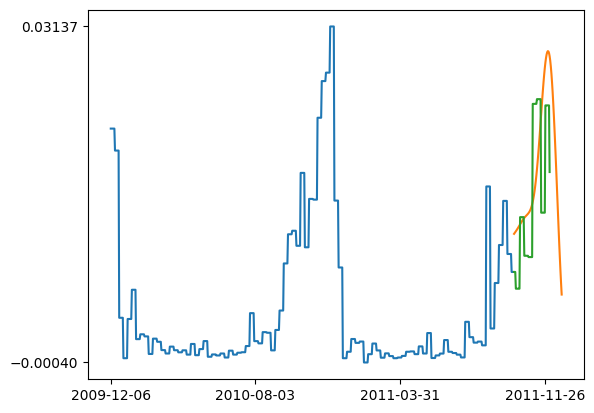

In [34]:
from prophet import Prophet

#data prep
ts = cluster_sales.T
ts.columns = [f'Cluster {i}' for i in ts.columns]
ts.index.name = 'Date'
ts = ts[ts.index != 'Cluster_id']
ts = ts[ts.index != 'MonthlySalesMean']
ts = ts[ts.index != 'MonthlySalesStddev']
ts = ts['Cluster 3']


ts_daily = pd.date_range(start=ts.index.min(),
                            end=ts.index.max(),
                            freq='D')
ts_daily = pd.DataFrame(index=ts_daily)
ts_daily.index.name='Date'
ts_daily['Sales'] = ts_daily.join(ts).ffill()
ts_daily['Sales'] = ts_daily['Sales'] / 7
ts_daily=ts_daily['Sales']
ts_daily_new = pd.DataFrame(columns=['ds','y'])
ts_daily_new['ds']= ts_daily.index
ts_daily_new['y']= ts_daily.values

ts_daily=ts_daily_new

prediction_period=60
cut_idx = int(len(ts_daily)-prediction_period)#prever um mes
ts_daily_train = ts_daily[:cut_idx]
ts_daily_test = ts_daily[cut_idx:]


modelo = Prophet(
    growth='flat',      
    yearly_seasonality=True,
    weekly_seasonality=False, 
    daily_seasonality=False
)

modelo.add_seasonality('yearly', period=(365.25), fourier_order=6)
modelo.add_country_holidays(country_name='UK')

modelo.fit(ts_daily_train)
forecast = modelo.predict(modelo.make_future_dataframe(periods=int(prediction_period*4/3),freq='D'))
forecast.set_index('ds',inplace=True)
ts_daily_train.set_index('ds',inplace=True)
ts_daily_test.set_index('ds',inplace=True)

plt.yticks((ts_daily['y'].min(), ts_daily['y'].max()))
plt.plot(ts_daily_train['y'])
plt.plot(forecast['yhat'].tail(int(prediction_period*4/3)))
plt.plot(ts_daily_test['y'])
plt.xticks(ts_daily_train.index.append(ts_daily_test.index)[::240])
plt.show()